**Review**

Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did a great job! The project is accepted. Good luck on the final sprint!

## Initialization

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import random

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [5]:
labels[labels.duplicated()]

,file_name,real_age


No nulls nor duplicates in the dataframe.

In [6]:
datagen = ImageDataGenerator(rescale=1. / 255)

In [7]:
train_datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels, # dataframe=
    directory='/datasets/faces/final_files/',  # the folder with the dataset
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,  # the batch size
    class_mode='raw',  # class mode
    # subset='training',  # indicate that this is the data generator for the training set
    seed=12345  # set a random number generator
)

Found 7591 validated image filenames.


In [8]:
features, target = next(train_datagen_flow)

## EDA

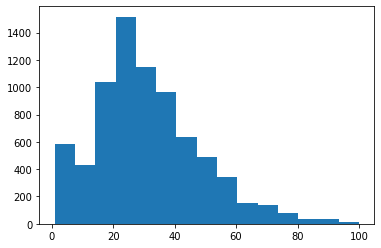

In [9]:
import matplotlib.pyplot as plt
plt.hist(labels['real_age'], bins=15)
plt.show()

In [10]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

94


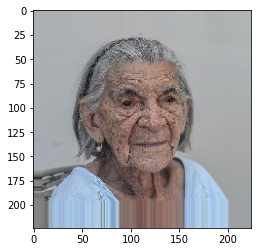

In [11]:
plt.imshow(features[19])
print(target[19])

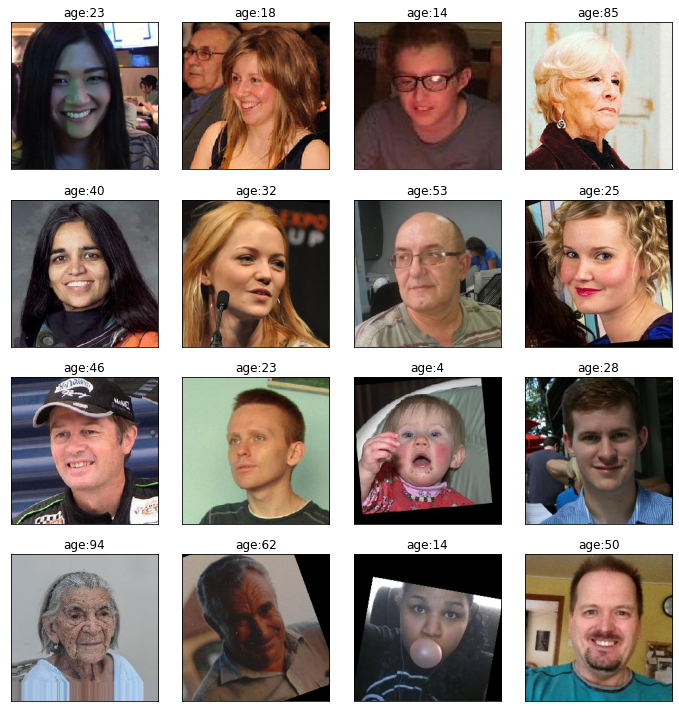

In [12]:
# display 16 images
fig = plt.figure(figsize=(10,10))
random_index_age = random.sample(range(31), 16)
for i in range(16):
    fig.add_subplot(4, 4, i+1).set_title('age:' + str(target[random_index_age[i]]))
    plt.imshow(features[random_index_age[i]])
    # remove axes and place the images closer to one another for a more compact output
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Findings

The age range most common in the dataset is from 20 to 40 years old as shown by the histogram and the descriptive statistics.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you explored the data a bit: checked target distribution and some examples of images

</div>

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [13]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [14]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    # place your code here
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1. / 255, horizontal_flip=True, vertical_flip=True,)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,  
        class_mode='raw',
        subset='training',
        seed=12345
    )
    
    return train_gen_flow

In [15]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    # place your code here
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1. / 255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,  
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    
    return test_gen_flow

<div class="alert alert-warning">
<b>Reviewer's comment</b>

The code for data loading is correct! Good idea to add augmentations for the training data, i'd avoid vertical flips though: human faces don't have upside-down symmetry

</div>

In [16]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    # place your code here
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)

    # freeze ResNet50 with the top removed
    backbone.trainable = False

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(12, activation='softmax'))
    optimizer = Adam(lr=0.01)
    model.compile(
        optimizer=optimizer,
        loss='mse',  # 'sparse_categorical_crossentropy',
        metrics=['mae']  # ['acc']
    )
    
    return model

In [17]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    # place your code here
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )
    
    return model

<div class="alert alert-success">
<b>Reviewer's comment</b>

The model is created and trained correctly

</div>

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [18]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

In [ ]:
# with open('run_model_on_gpu.py', "w") as f:
#  file_contents = f.read()
#  print(file_contents)

Below is output of the Model Training done in the previous lesson.

Epoch 1/20

356/356 - 35s - loss: 95.3532 - mae: 7.4339 - val_loss: 124.3362 - val_mae: 8.4921

Epoch 2/20

356/356 - 35s - loss: 76.8372 - mae: 6.6707 - val_loss: 127.6357 - val_mae: 8.6035

Epoch 3/20

356/356 - 35s - loss: 69.9428 - mae: 6.3992 - val_loss: 91.1531 - val_mae: 7.4454

Epoch 4/20

356/356 - 35s - loss: 64.4249 - mae: 6.1407 - val_loss: 124.0287 - val_mae: 8.3481

Epoch 5/20

356/356 - 35s - loss: 52.8486 - mae: 5.5913 - val_loss: 109.1004 - val_mae: 8.2192

Epoch 6/20

356/356 - 35s - loss: 46.3094 - mae: 5.2223 - val_loss: 85.1038 - val_mae: 7.0332

Epoch 7/20

356/356 - 35s - loss: 38.2617 - mae: 4.7951 - val_loss: 92.0900 - val_mae: 7.3359

Epoch 8/20

356/356 - 35s - loss: 37.4804 - mae: 4.7402 - val_loss: 80.0016 - val_mae: 6.7239

Epoch 9/20

356/356 - 35s - loss: 33.5237 - mae: 4.4271 - val_loss: 83.2579 - val_mae: 6.8529

Epoch 10/20

356/356 - 35s - loss: 28.5170 - mae: 4.1411 - val_loss: 83.5056 - val_mae: 6.9629

Epoch 11/20

356/356 - 35s - loss: 27.0142 - mae: 3.9700 - val_loss: 92.1290 - val_mae: 7.1866

Epoch 12/20

356/356 - 35s - loss: 27.4564 - mae: 4.0428 - val_loss: 185.6307 - val_mae: 11.4591

Epoch 13/20

356/356 - 35s - loss: 23.7961 - mae: 3.7407 - val_loss: 92.3429 - val_mae: 7.2467

Epoch 14/20

356/356 - 35s - loss: 24.6167 - mae: 3.8116 - val_loss: 92.4542 - val_mae: 7.1401

Epoch 15/20

356/356 - 35s - loss: 22.2604 - mae: 3.6746 - val_loss: 82.5822 - val_mae: 6.7841

Epoch 16/20

356/356 - 35s - loss: 20.1899 - mae: 3.4430 - val_loss: 86.3830 - val_mae: 6.8304

Epoch 17/20

356/356 - 35s - loss: 17.3425 - mae: 3.2205 - val_loss: 78.4369 - val_mae: 6.6419

Epoch 18/20

356/356 - 35s - loss: 16.5249 - mae: 3.1295 - val_loss: 81.7731 - val_mae: 6.7226

Epoch 19/20

356/356 - 35s - loss: 16.6140 - mae: 3.1421 - val_loss: 80.9727 - val_mae: 6.9908

Epoch 20/20

356/356 - 35s - loss: 17.0187 - mae: 3.1785 - val_loss: 93.4115 - val_mae: 7.6512

<div class="alert alert-success">
<b>Reviewer's comment</b>

Model training was successful

</div>

## Conclusions

With 20 epochs, the modelling functions from the Model Training lesson were able to obtain a mean absolute value under 8, although, 18 epochs provided some of the better values across both the loss and MAE values. This relatively low score showed the strength of using ResNet50 in the model versus manually adding multiple layers.

This computer vision can definietly help the supermarket chain Good Seed by flagging people under the age of buying alcohol. Since it is not fullproof, it can at least eliminate the need of checking those deemed much older. Additionaly, the computer vision can help match certain age groups to specific types of products. So, if a local store has a large demographic of a certain age group, they can stock a larger portion of the store with goods that cater to that age of people.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Good points!

</div>

# Checklist

- [ ]  Notebook was opened
- [ ]  The code is error free
- [ ]  The cells with code have been arranged by order of execution
- [ ]  The exploratory data analysis has been performed
- [ ]  The results of the exploratory data analysis are presented in the final notebook
- [ ]  The model's MAE score is not higher than 8
- [ ]  The model training code has been copied to the final notebook
- [ ]  The model training output has been copied to the final notebook
- [ ]  The findings have been provided based on the results of the model training